# Fundamental Plasma Parameters
This tutorial shows how to calculate some fundamental parameters that are typically used to characterize the ionospheric plasma from AMISR data files.  The equations used here are sourced from the NRL Plasma Formulary p28-29 {cite}`NRLPF` and Schunk & Nagy, 2009, p45 and p141 {cite}`Schunk2009`.

In [2]:
import h5py
import os
import urllib.request
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

Download files that will be used in this tutorial.

In [4]:
# Download the file that we need to run these examples
filename = '../../data/20200207.001_lp_5min-fitcal.h5'

if not os.path.exists(filename):
    url='https://data.amisr.com/database/dbase_site_media/PFISR/Experiments/20200207.001/DataFiles/20200207.001_lp_5min-fitcal.h5'

    print('Downloading data file...')
    urllib.request.urlretrieve(url, filename)

    print('...Done!')


**Note on Ions:** There are multiple relevant ion species in the ionosphere.  Ion mass  $m_i$ can be found by multiplying the `IonMass` array by the mass of a proton.  The [Fits Array](fits) includes the fractional ion composition, which can be used to calculate the density of indiviual ion species by multipying by the electron density (see [Ion Composition](ion_comp) for more details).  These operations may require some array broadcasting and expand the size of the array to include a species dimension.

In [5]:
with h5py.File(filename, 'r') as h5:
    ne = h5['FittedParams/Ne'][:]
    frac = h5['FittedParams/Fits'][:,:,:,:,0]
    ion_mass = h5['FittedParams/IonMass'][:]

ni = np.expand_dims(ne,axis=-1)*frac[:,:,:,:-1]
mi = ion_mass*const.m_p
print(ne.shape, ni.shape)

for am, m in zip(ion_mass, mi):
    print(f'{am} AMU = {m} km')

mass_labels = {16:'O+', 32:'O2+', 30:'NO+', 28:'N2+', 14:'N+'}

(188, 11, 74) (188, 11, 74, 5)
16.0 AMU = 2.676195077904e-26 km
32.0 AMU = 5.352390155808e-26 km
30.0 AMU = 5.01786577107e-26 km
28.0 AMU = 4.6833413863320004e-26 km
14.0 AMU = 2.3416706931660002e-26 km


The ion density array has the standard dimensions for record, beam, and bin, plus an additional one for the five ion species.  Many of the general equations shown below include $e_\alpha$, which is used to indicate absolute value of charge the species.  For the ionospheric regimes relevant to ISR measurments, ions normally only have +1 charge states, so $e_\alpha = e$ and $e_\alpha$ will be implicitly replaced with just the elementary charge, $e$, in coding examples.

In [6]:
# Load some parameters from the file that are only needed for plotting
with h5py.File(filename, 'r') as h5:
    beamcodes = h5['BeamCodes'][:]
    bidx = np.argmax(beamcodes[:,2])
    alt = h5['Geomag/Altitude'][:]
    utime = h5['Time/UnixTime'][:,0]
time = utime.astype('datetime64[s]')

## Collision Frequency
The collision frequencies are contained directly within the AMISR files.  Although these look fairly uniform, there are small differences between species and over time.

Text(0, 0.5, 'Altitude (m)')

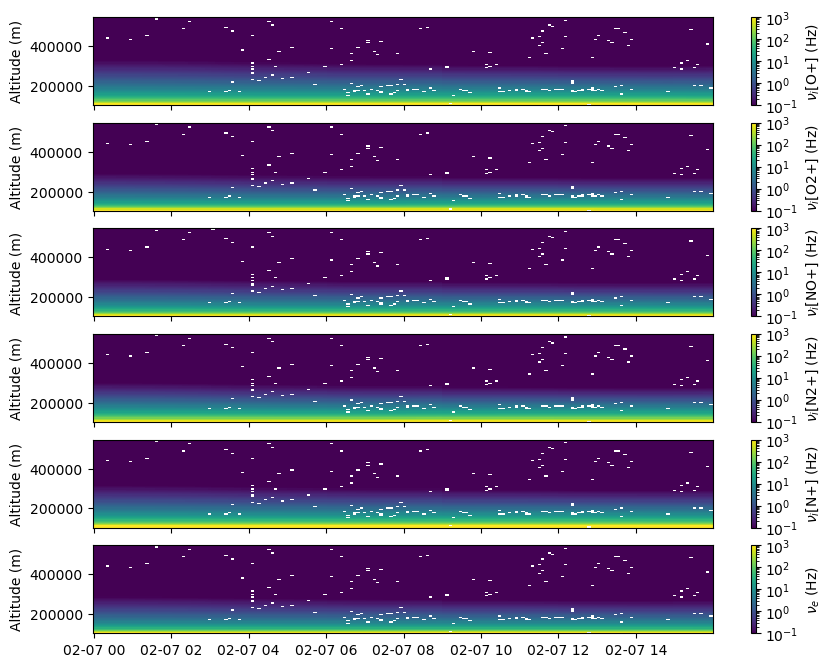

In [23]:
with h5py.File(filename, 'r') as h5:
    nu_i = h5['FittedParams/Fits'][:,:,:,:-1,2]
    nu_e = h5['FittedParams/Fits'][:,:,:,-1,2]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(len(ion_mass)+1,1)
norm = colors.LogNorm(vmin=1.e-1, vmax=1.e3)
for i in range(len(ion_mass)):
    ax = fig.add_subplot(gs[i])
    c = ax.pcolormesh(time, alt[bidx,:], nu_i[:,bidx,:,i].T, norm=norm)
    fig.colorbar(c, label=rf'$\nu_i$[{mass_labels[int(ion_mass[i])]}] (Hz)')
    ax.set_xticklabels([])
    ax.set_ylabel('Altitude (m)')
ax = fig.add_subplot(gs[-1])
c = ax.pcolormesh(time, alt[bidx,:], nu_e[:,bidx,:].T, norm=colors.LogNorm(vmin=1.e-1, vmax=1.e3))
fig.colorbar(c, label=r'$\nu_e$ (Hz)')
ax.set_ylabel('Altitude (m)')
# fig.colorbar(c)

## Debye Length
The Debye length is the minimum distance over which plasma can exhibit collective behavior.

$$ \lambda_D = \sqrt{\frac{\epsilon_0 k_B T_e}{n_e e^2}} $$

(188, 11, 74)


/var/folders/yf/c17s54f12c1bg0cxdywsxyxjssh4z4/T/ipykernel_17406/1096541457.py:5: RuntimeWarning: invalid value encountered in sqrt
  lam_D = np.sqrt((const.epsilon_0*const.k*te)/(ne*const.e**2))


Text(0, 0.5, 'Altitude (m)')

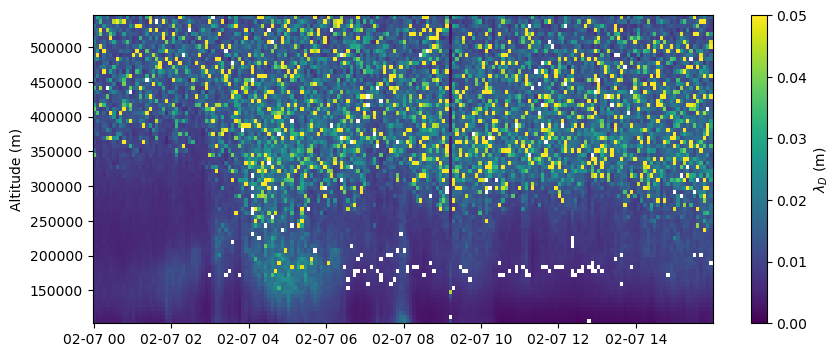

In [7]:
with h5py.File(filename, 'r') as h5:
    ne = h5['FittedParams/Ne'][:]
    te = h5['FittedParams/Fits'][:,:,:,-1,1]

lam_D = np.sqrt((const.epsilon_0*const.k*te)/(ne*const.e**2))
print(lam_D.shape)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()
c = ax.pcolormesh(time, alt[bidx,:], lam_D[:,bidx,:].T, vmin=0., vmax=0.05)
fig.colorbar(c, label=r'$\lambda_D$ (m)')
ax.set_ylabel('Altitude (m)')

## Thermal Velocity
$$ v_{T\alpha} = \sqrt{\frac{k_B T_\alpha}{m_\alpha}} $$

(188, 11, 74) (188, 11, 74, 5)


/var/folders/yf/c17s54f12c1bg0cxdywsxyxjssh4z4/T/ipykernel_17406/1018191487.py:6: RuntimeWarning: invalid value encountered in sqrt
  v_te = np.sqrt(const.k*te/const.m_e)
/var/folders/yf/c17s54f12c1bg0cxdywsxyxjssh4z4/T/ipykernel_17406/1018191487.py:7: RuntimeWarning: invalid value encountered in sqrt
  v_ti = np.sqrt(const.k*ti/(ion_mass*const.m_p))


Text(0, 0.5, 'Altitude (m)')

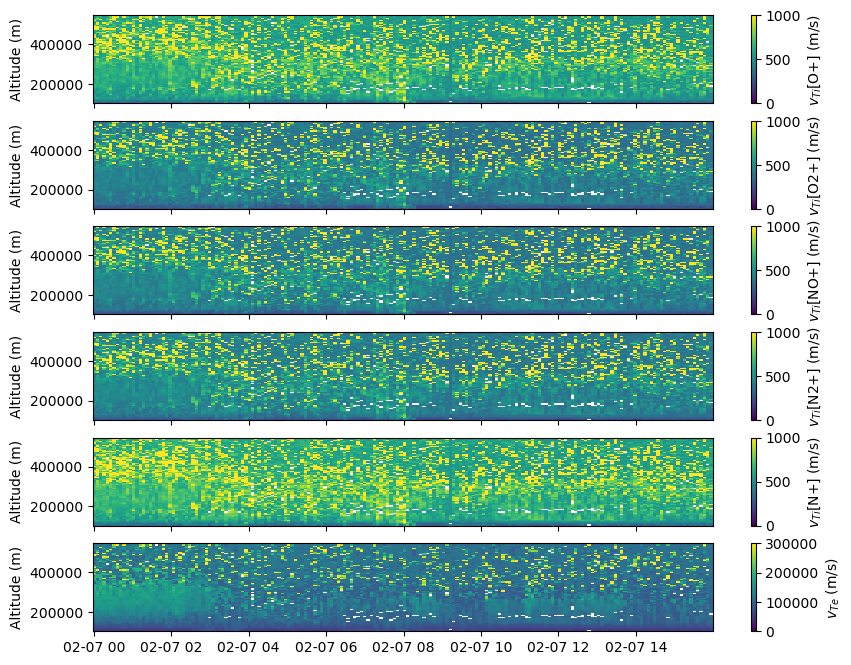

In [24]:
with h5py.File(filename, 'r') as h5:
    ion_mass = h5['FittedParams/IonMass'][:]
    te = h5['FittedParams/Fits'][:,:,:,-1,1]
    ti = h5['FittedParams/Fits'][:,:,:,:-1,1]

v_te = np.sqrt(const.k*te/const.m_e)
v_ti = np.sqrt(const.k*ti/(ion_mass*const.m_p))
print(v_te.shape, v_ti.shape)

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(len(ion_mass)+1,1)
for i in range(len(ion_mass)):
    ax = fig.add_subplot(gs[i])
    c=ax.pcolormesh(time, alt[bidx,:], v_ti[:,bidx,:,i].T, vmin=0., vmax=1.e3)
    fig.colorbar(c, label=rf'$v_{{Ti}}$[{mass_labels[int(ion_mass[i])]}] (m/s)')
    ax.set_xticklabels([])
    ax.set_ylabel('Altitude (m)')
ax = fig.add_subplot(gs[-1])
c=ax.pcolormesh(time, alt[bidx,:], v_te[:,bidx,:].T, vmin=0., vmax=3.e5)
fig.colorbar(c, label=r'$v_{Te}$ (m/s)')
ax.set_ylabel('Altitude (m)')

## Gyrofrequency
The frequency at which charged particles gyrate around the magnetic field line.  This is also called the cyclotron frequency.

$$ \omega_{c\alpha} = \frac{e_\alpha B}{m_\alpha} $$

Becasue there are no time-dependent parameters in the gyrofrequency, it only has a single value for each beam, bin, and species in the array (no record dimension)

Text(0, 0.5, 'Altitude (m)')

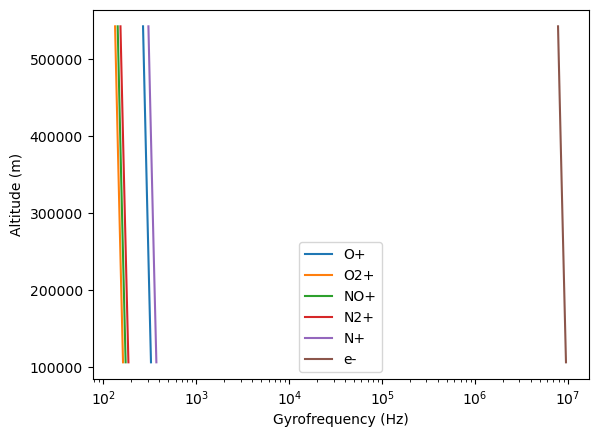

In [25]:
with h5py.File(filename, 'r') as h5:
    B = h5['Geomag/Babs'][:]
    ion_mass = h5['FittedParams/IonMass'][:]

omega_ce = const.e*B/(const.m_e)
omega_ci = const.e*np.expand_dims(B,axis=-1)/(ion_mass*const.m_p)

fig = plt.figure()
ax = fig.add_subplot()
for i in range(len(ion_mass)):
    ax.plot(omega_ci[bidx,:,i], alt[bidx], label=mass_labels[int(ion_mass[i])])
ax.plot(omega_ce[bidx], alt[bidx], label='e-')
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Gyrofrequency (Hz)')
ax.set_ylabel('Altitude (m)')

## Gyroradius
The gyroradius is the radius at which charged particles gyrate around the magnetic field.

$$ r_\alpha = \frac{v_{T\alpha}}{\omega_{c\alpha}} = \frac{\sqrt{2 k_B T_\alpha/m_\alpha}}{\omega_{c\alpha}} $$


/var/folders/yf/c17s54f12c1bg0cxdywsxyxjssh4z4/T/ipykernel_17406/3293154337.py:8: RuntimeWarning: invalid value encountered in sqrt
  re = np.sqrt(2*const.k*te/const.m_e)/omega_ce
/var/folders/yf/c17s54f12c1bg0cxdywsxyxjssh4z4/T/ipykernel_17406/3293154337.py:10: RuntimeWarning: invalid value encountered in sqrt
  ri = np.sqrt(2*const.k*ti/(ion_mass*const.m_p))/omega_ci


Text(0, 0.5, 'Altitude (m)')

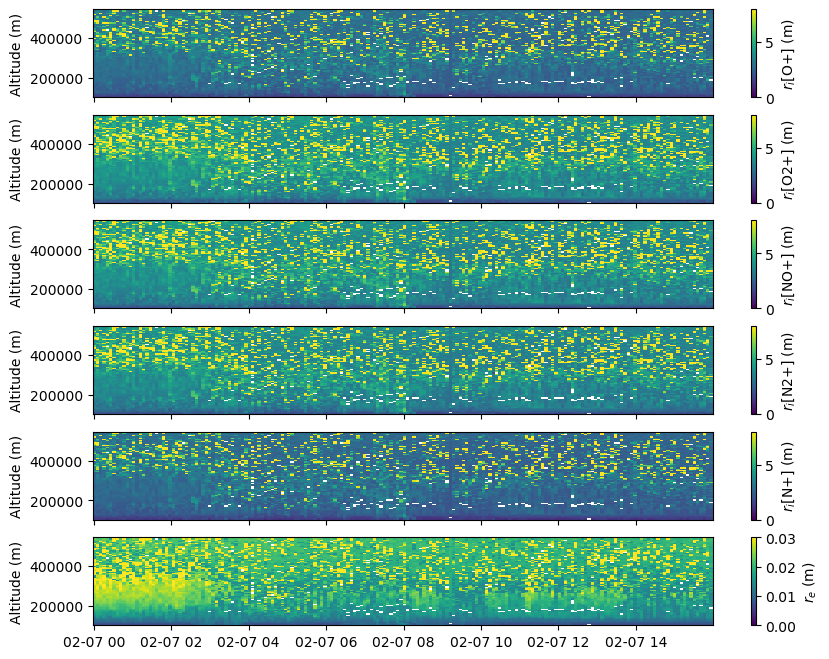

In [27]:
with h5py.File(filename, 'r') as h5:
    B = h5['Geomag/Babs'][:]
    ion_mass = h5['FittedParams/IonMass'][:]
    te = h5['FittedParams/Fits'][:,:,:,-1,1]
    ti = h5['FittedParams/Fits'][:,:,:,:-1,1]

omega_ce = const.e*B/const.m_e
re = np.sqrt(2*const.k*te/const.m_e)/omega_ce
omega_ci = const.e*np.expand_dims(B,axis=-1)/(ion_mass*const.m_p)
ri = np.sqrt(2*const.k*ti/(ion_mass*const.m_p))/omega_ci

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(len(ion_mass)+1,1)

for i in range(len(ion_mass)):
    ax = fig.add_subplot(gs[i])
    c = ax.pcolormesh(time, alt[bidx,:], ri[:,bidx,:,i].T, vmin=0., vmax=8.)
    fig.colorbar(c, label=rf'$r_i$[{mass_labels[int(ion_mass[i])]}] (m)')
    ax.set_xticklabels([])
    ax.set_ylabel('Altitude (m)')
ax = fig.add_subplot(gs[-1])
c = ax.pcolormesh(time, alt[bidx,:], re[:,bidx,:].T, vmin=0., vmax=0.03)
fig.colorbar(c, label=r'$r_e$ (m)')
ax.set_ylabel('Altitude (m)')

## Plasma frequency
This describes the response of particles to time-varying electric fields.

$$ \omega_{p\alpha} = \sqrt{\frac{n_\alpha e_\alpha^2}{\epsilon_0 m_\alpha}} $$


(188, 11, 74) (188, 11, 74, 6) (5,) (11, 74)
(188, 11, 74) (188, 11, 74, 5)


/var/folders/yf/c17s54f12c1bg0cxdywsxyxjssh4z4/T/ipykernel_17406/2494080944.py:11: RuntimeWarning: invalid value encountered in sqrt
  omega_pe = np.sqrt((ne*const.e**2)/(const.epsilon_0*const.m_e))
/var/folders/yf/c17s54f12c1bg0cxdywsxyxjssh4z4/T/ipykernel_17406/2494080944.py:12: RuntimeWarning: invalid value encountered in sqrt
  omega_pi = np.sqrt((ni*const.e**2)/(const.epsilon_0*ion_mass*const.m_p))


Text(0, 0.5, 'Altitude (m)')

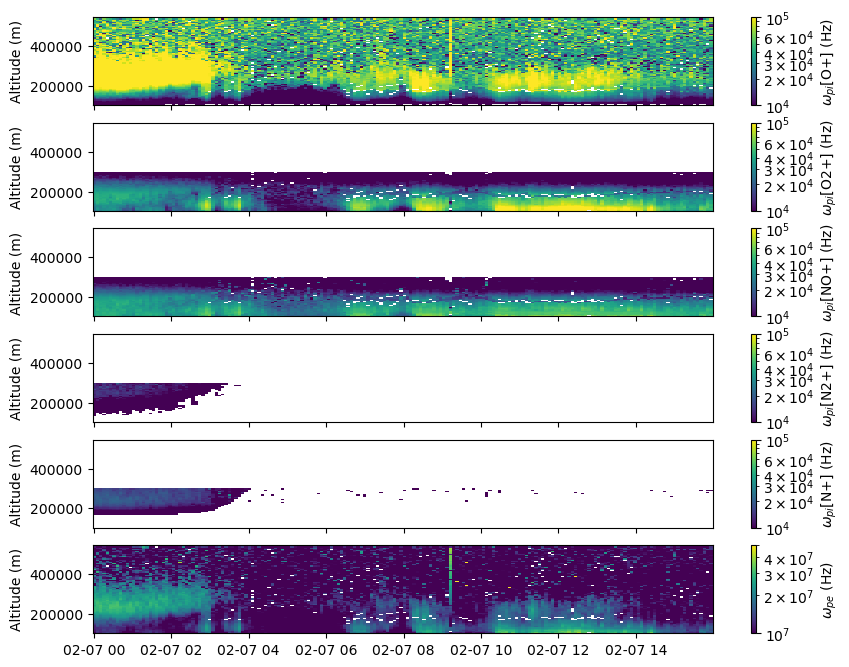

In [28]:
with h5py.File(filename, 'r') as h5:
    ne = h5['FittedParams/Ne'][:]
    frac = h5['FittedParams/Fits'][:,:,:,:,0]
    ion_mass = h5['FittedParams/IonMass'][:]
    # alt = h5['Geomag/Altitude'][:]

print(ne.shape, frac.shape, ion_mass.shape, alt.shape)

ni = np.expand_dims(ne,axis=-1)*frac[:,:,:,:-1]

omega_pe = np.sqrt((ne*const.e**2)/(const.epsilon_0*const.m_e))
omega_pi = np.sqrt((ni*const.e**2)/(const.epsilon_0*ion_mass*const.m_p))

print(omega_pe.shape, omega_pi.shape)

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(len(ion_mass)+1,1)
norm = colors.LogNorm(vmin=1.e4, vmax=1.e5)
for i in range(len(ion_mass)):
    ax = fig.add_subplot(gs[i])
    c = ax.pcolormesh(time, alt[bidx,:], omega_pi[:,bidx,:,i].T, norm=norm)
    fig.colorbar(c, label=rf'$\omega_{{pi}}$[{mass_labels[int(ion_mass[i])]}] (Hz)')
    ax.set_xticklabels([])
    ax.set_ylabel('Altitude (m)')
ax = fig.add_subplot(gs[-1])
c = ax.pcolormesh(time, alt[bidx,:], omega_pe[:,bidx,:].T, norm=colors.LogNorm(vmin=1.e7, vmax=5.e7))
fig.colorbar(c, label=r'$\omega_{pe}$ (Hz)')
ax.set_ylabel('Altitude (m)')
# fig.colorbar(c)

## Inertial Length

$$ d_\alpha = \frac{c}{\omega_{p\alpha}} $$


(188, 11, 74) (188, 11, 74, 6) (5,) (11, 74)
(188, 11, 74) (188, 11, 74, 5)


/var/folders/yf/c17s54f12c1bg0cxdywsxyxjssh4z4/T/ipykernel_17406/2677437031.py:11: RuntimeWarning: invalid value encountered in sqrt
  omega_pe = np.sqrt((ne*const.e**2)/(const.epsilon_0*const.m_e))
/var/folders/yf/c17s54f12c1bg0cxdywsxyxjssh4z4/T/ipykernel_17406/2677437031.py:12: RuntimeWarning: invalid value encountered in sqrt
  omega_pi = np.sqrt((ni*const.e**2)/(const.epsilon_0*ion_mass*const.m_p))
/var/folders/yf/c17s54f12c1bg0cxdywsxyxjssh4z4/T/ipykernel_17406/2677437031.py:13: RuntimeWarning: divide by zero encountered in divide
  di = const.c/omega_pi


Text(0, 0.5, 'Altitude (m)')

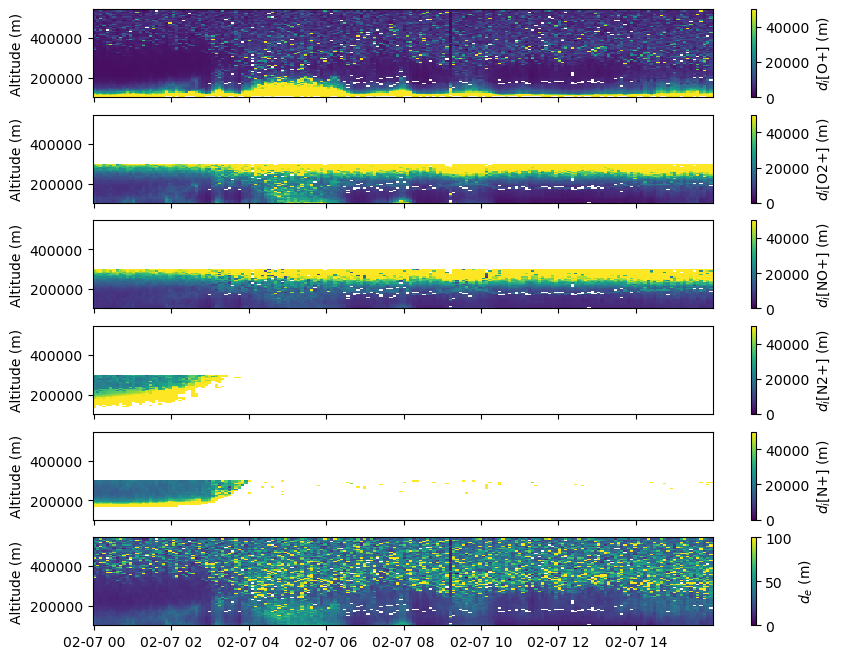

In [29]:
with h5py.File(filename, 'r') as h5:
    ne = h5['FittedParams/Ne'][:]
    frac = h5['FittedParams/Fits'][:,:,:,:,0]
    ion_mass = h5['FittedParams/IonMass'][:]
    # alt = h5['Geomag/Altitude'][:]

print(ne.shape, frac.shape, ion_mass.shape, alt.shape)

ni = np.expand_dims(ne,axis=-1)*frac[:,:,:,:-1]

omega_pe = np.sqrt((ne*const.e**2)/(const.epsilon_0*const.m_e))
omega_pi = np.sqrt((ni*const.e**2)/(const.epsilon_0*ion_mass*const.m_p))
di = const.c/omega_pi
de = const.c/omega_pe

print(de.shape, di.shape)

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(len(ion_mass)+1,1)
# norm = colors.LogNorm(vmin=1.e4, vmax=1.e5)
for i in range(len(ion_mass)):
    ax = fig.add_subplot(gs[i])
    c = ax.pcolormesh(time, alt[bidx,:], di[:,bidx,:,i].T, vmin=0., vmax=5.e4)
    fig.colorbar(c, label=rf'$d_i$[{mass_labels[int(ion_mass[i])]}] (m)')
    ax.set_xticklabels([])
    ax.set_ylabel('Altitude (m)')
ax = fig.add_subplot(gs[-1])
c = ax.pcolormesh(time, alt[bidx,:], de[:,bidx,:].T, vmin=0., vmax=1.e2)
fig.colorbar(c, label=r'$d_e$ (m)')
ax.set_ylabel('Altitude (m)')

## Hall Conductivity

$$ \sigma_H = \frac{n_e e^2}{m_e}\frac{\omega_{ce}}{\nu_e^2+\omega_{ce}^2} - \sum_i \frac{n_i e^2}{m_i}\frac{\omega_{ci}}{\nu_i^2+\omega_{ci}^2} $$


(188, 11, 74)


Text(0, 0.5, 'Altitude (m)')

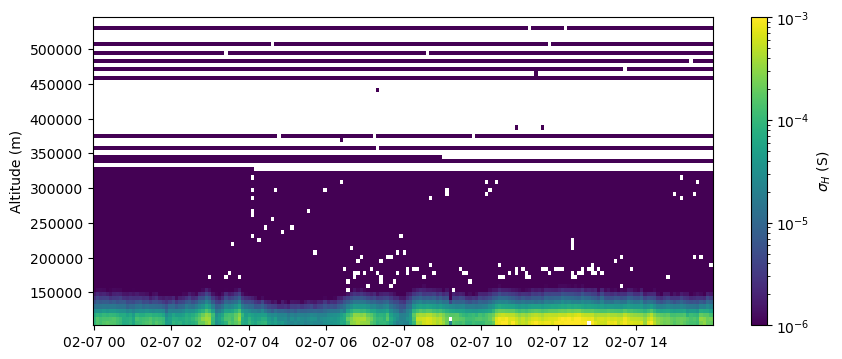

In [30]:
with h5py.File(filename, 'r') as h5:
    B = h5['Geomag/Babs'][:]
    ion_mass = h5['FittedParams/IonMass'][:]
    frac = h5['FittedParams/Fits'][:,:,:,:,0]
    nu_i = h5['FittedParams/Fits'][:,:,:,:-1,2]
    nu_e = h5['FittedParams/Fits'][:,:,:,-1,2]
    ne = h5['FittedParams/Ne'][:]

ni = np.expand_dims(ne,axis=-1)*frac[:,:,:,:-1]
omega_ce = const.e*B/(const.m_e)
omega_ci = const.e*np.expand_dims(B,axis=-1)/(ion_mass*const.m_p)

sigma_H = (ne*const.e**2)/const.m_e*omega_ce/(nu_e**2+omega_ce**2) - np.sum((ni*const.e**2)/(ion_mass*const.m_p)*omega_ci/(nu_i**2+omega_ci**2), axis=-1)
print(sigma_H.shape)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()
c = ax.pcolormesh(time, alt[bidx,:], sigma_H[:,bidx,:].T, norm=colors.LogNorm(vmin=1.e-6, vmax=1e-3))
fig.colorbar(c, label=r'$\sigma_H$ (S)')
ax.set_ylabel('Altitude (m)')

## Pedersen Conductivity

$$ \sigma_P = \frac{n_e e^2}{m_e}\frac{\nu_e}{\nu_e^2+\omega_{ce}^2} + \sum_i \frac{n_i e^2}{m_i}\frac{\nu_i}{\nu_i^2+\omega_{ci}^2} $$


(188, 11, 74)


Text(0, 0.5, 'Altitude (m)')

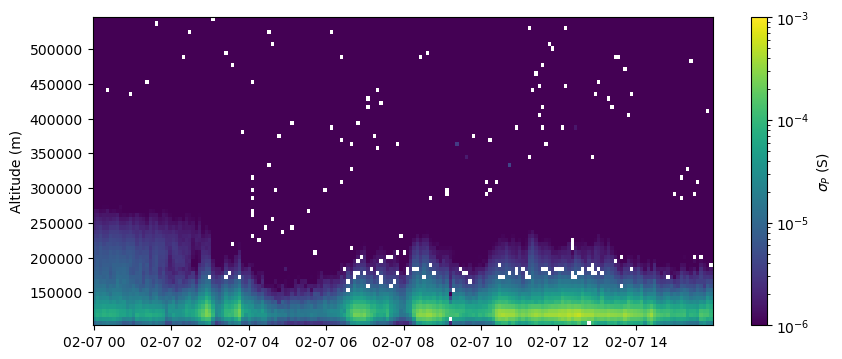

In [31]:
with h5py.File(filename, 'r') as h5:
    B = h5['Geomag/Babs'][:]
    ion_mass = h5['FittedParams/IonMass'][:]
    frac = h5['FittedParams/Fits'][:,:,:,:,0]
    nu_i = h5['FittedParams/Fits'][:,:,:,:-1,2]
    nu_e = h5['FittedParams/Fits'][:,:,:,-1,2]
    ne = h5['FittedParams/Ne'][:]

ni = np.expand_dims(ne,axis=-1)*frac[:,:,:,:-1]
omega_ce = const.e*B/(const.m_e)
omega_ci = const.e*np.expand_dims(B,axis=-1)/(ion_mass*const.m_p)

sigma_P = (ne*const.e**2)/const.m_e*nu_e/(nu_e**2+omega_ce**2) + np.sum((ni*const.e**2)/(ion_mass*const.m_p)*nu_i/(nu_i**2+omega_ci**2), axis=-1)
print(sigma_P.shape)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()
c = ax.pcolormesh(time, alt[bidx,:], sigma_P[:,bidx,:].T, norm=colors.LogNorm(vmin=1.e-6, vmax=1e-3))
fig.colorbar(c, label=r'$\sigma_P$ (S)')
ax.set_ylabel('Altitude (m)')